# Affine Transform - Train Neural Network

## Introduction

In this notebook, a two-hidden-layer network $N\!N_o$ ($L=2$) is trained with $3$ nodes in each layer to learn a 45-degrees-counterclockwise rotation function $Rot:\mathcal{X}_o\rightarrow\mathcal{T}$ in 2D space using *Tensorflow*. 
The original input space is $\mathcal{X}_o = \{\mathbf{x}^0=[x,y]\in \mathbb{R}^2\;|\; 1\leq x,y\leq4\}$. The output space $\mathcal{T}$ 
represents the set of counterclockwise rotated points in $\mathcal{X}_o$ by $\pi/4$ rad defined as 
$\mathcal{T}=\{\mathbf{y}\in\mathbb{R}^{2}\;|\;\mathbf{y}=Rot(\mathbf{x}_0)\text{ for }\mathbf{x}^0\in\mathcal{X}_o\}$. 

This netwrok is then repaired to push all the outputs $\mathbf{y}$ inside a Quadrilateral defined by
\begin{align*}
    \Psi(\mathbf{y},\mathbf{x}^0)=\left\{\mathbf{y}\in\mathcal{T}\;|\;\lVert[x,y] - [2.5,2.5]\rVert_1\leq \frac{5\sqrt{2}}{4}\right\},
\end{align*}
where $\lVert\cdot\rVert_1$ denotes the $L_1$ norm and $\mathcal{X}_r=\mathcal{X}_o$. 
The repair code is provided in [*Affine_transform_repair.ipynb*](demos/Affine_Transform_Demo_Tensorflow/Affine_Transform_Repair.ipynb).

-----------------


In [1]:
from tensorflow import keras
import numpy as np
from shapely.geometry import Polygon
from affine_utils import gen_rand_points_within_poly, Batch
import pickle
import os
from matplotlib import pyplot as plt
import matplotlib as mpl

Create a path to store the trained model and data set.

In [2]:
path = os.path.join(os.getcwd(), "original_net")
if not os.path.exists(path):
    os.makedirs(path)
    print("The new directory is created!")
    

## Data Generation

Start by creating a dataset for the neural network that learns an Affine Transform in a 2d space.
We use 250 samples with 80% for training and 20% for testing.

In [3]:
num_pts = 250  # number of samples
train2test_ratio = 0.8 # train/test ratio

Here, we define the translation and rotation matrices.

In [7]:
# translation matrix 1
translate1 = np.array(
    [[1, 0, 2.5], [0, 1, 2.5], [0, 0, 1]]
)  
# translation matrix 2
translate2 = np.array(
    [[1, 0, -2.5], [0, 1, -2.5], [0, 0, 1]]
) 
# rotation matrix
rotate = np.array(
    [
        [np.cos(np.pi / 4), -np.sin(np.pi / 4), 0],
        [np.sin(np.pi / 4), np.cos(np.pi / 4), 0],
        [0, 0, 1],
    ]
)  

Below, we define the polygons representing input, output, and contraint sets, respectively.

In [8]:
# polygon representing the original set
poly_orig = Polygon([(1, 1), (4, 1), (4, 4), (1, 4)])

# polygon representing the rotated set
poly_trans = Polygon([(2.5, 4.621), (4.624, 2.5), (2.5, 0.3787), (0.3787, 2.5)])

# vertices of the input set
vert_const_inp = np.array(
    [[1.25, 3.75, 3.75, 1.25], [1.25, 1.25, 3.75, 3.75], [1, 1, 1, 1]]
) 

# vertices of the output set
vert_const_out = np.matmul(np.matmul(np.matmul(translate1, rotate), translate2), vert_const_inp)
  
# polygon representing the constraint set
poly_const = Polygon(
    [
        (vert_const_out[0, 0], vert_const_out[1, 0]),
        (vert_const_out[0, 1], vert_const_out[1, 1]),
        (vert_const_out[0, 2], vert_const_out[1, 2]),
        (vert_const_out[0, 3], vert_const_out[1, 3]),
    ]
)

Now, we extract rotation samples and construct a data batch.

In [10]:
# generate rotation samples
x = gen_rand_points_within_poly(poly_orig, num_pts)
y = np.matmul(np.matmul(np.matmul(translate1, rotate), translate2), x.T)
y = y.T

# construct a data batch class
batch_size = int(train2test_ratio * num_pts)
batch = Batch(x, y, batch_size)

# extract training and testing samples
x_train, y_train, x_test, y_test = batch.get_batch()
print(f"Data size: {num_pts}")
print(f"Train/Test Split: {train2test_ratio}")
print(f"Training Set Size = {x_train.shape}")
print(f"Testing Set Size = {x_test.shape}")


Data size: 250
Train/Test Split: 0.8
Training Set Size = (200, 3)
Testing Set Size = (50, 3)


## Neural Network Specification

Now that we have the dataset ready, let us start by defining the neural network to learn this affine transform. We first define the network parameters.

In [11]:
input_dim = 3  # input size
output_dim = 3 # output size
hid_dim_0 = 3  # hidden layer0 size
hid_dim_1 = 3  # hidden layer1 size
regularizer_rate = 0.001 # regularization rate
train_epochs = 1000 # training epochs
learning_rate = 0.003 # learning rate

We then define the network architecture.

In [12]:
model_orig = keras.Sequential(name="3_layer_NN")
model_orig.add(
    keras.layers.Dense(
        hid_dim_0,
        activation="relu",
        kernel_regularizer=keras.regularizers.l2(regularizer_rate),
        bias_regularizer=keras.regularizers.l2(regularizer_rate),
        input_shape=(input_dim,),
        name="layer0",
    )
)
model_orig.add(
    keras.layers.Dense(
        hid_dim_1,
        activation="relu",
        kernel_regularizer=keras.regularizers.l2(regularizer_rate),
        bias_regularizer=keras.regularizers.l2(regularizer_rate),
        name="layer1",
    )
)
model_orig.add(
    keras.layers.Dense(
        output_dim,
        kernel_regularizer=keras.regularizers.l2(regularizer_rate),
        bias_regularizer=keras.regularizers.l2(regularizer_rate),
        name="output",
    )
)

model_orig.summary()

Model: "3_layer_NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer0 (Dense)              (None, 3)                 12        
                                                                 
 layer1 (Dense)              (None, 3)                 12        
                                                                 
 output (Dense)              (None, 3)                 12        
                                                                 
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________


2022-04-28 22:25:53.623171: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now, we train the neural network using mean square loss.

In [13]:
loss = keras.losses.MeanSquaredError(name="MSE")
optimizer = keras.optimizers.Adam(learning_rate=learning_rate, name="Adam")
model_orig.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

his = model_orig.fit(
    x_train,
    y_train,
    epochs=train_epochs,
    use_multiprocessing=True,
    verbose=0,
)
print("Model Loss + Accuracy on Test Data Set: ")
model_orig.evaluate(x_test, y_test, verbose=2)

Model Loss + Accuracy on Test Data Set: 
2/2 - 0s - loss: 0.0101 - accuracy: 1.0000 - 160ms/epoch - 80ms/step


[0.010101234540343285, 1.0]

## Input - Output Visualization

Below shows the predicted outputs given the training and testing data sets.

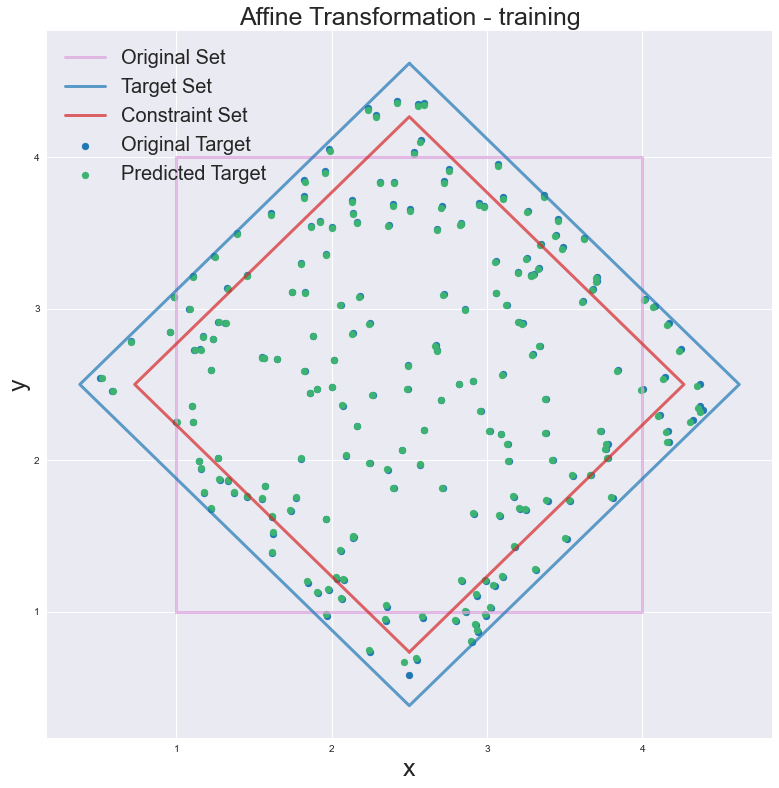

In [17]:
plt.rcParams["text.usetex"] = False
mpl.style.use("seaborn")
plt.rcParams["figure.figsize"] = (13,13)
x_poly_trans_bound, y_poly_trans_bound = poly_trans.exterior.xy
x_poly_orig_bound, y_poly_orig_bound = poly_orig.exterior.xy
x_poly_const_bound, y_poly_const_bound = poly_const.exterior.xy

## predicted output (training dataset)
plt.plot(
    x_poly_orig_bound,
    y_poly_orig_bound,
    color="plum",
    alpha=0.7,
    linewidth=3,
    solid_capstyle="round",
    zorder=2,
    label="Original Set",
)
plt.plot(
    x_poly_trans_bound,
    y_poly_trans_bound,
    color="tab:blue",
    alpha=0.7,
    linewidth=3,
    solid_capstyle="round",
    zorder=2,
    label="Target Set",
)
plt.plot(
    x_poly_const_bound,
    y_poly_const_bound,
    color="tab:red",
    alpha=0.7,
    linewidth=3,
    solid_capstyle="round",
    zorder=2,
    label="Constraint Set",
)
plt.scatter(
    y_train[:, 0],
    y_train[:, 1],
    color="tab:blue",
    label="Original Target",
)
y_predict_train = model_orig.predict(x_train)
plt.scatter(
    y_predict_train[:, 0],
    y_predict_train[:, 1],
    color="mediumseagreen",
    label="Predicted Target",
)
plt.legend(loc="upper left", frameon=False, fontsize=20)
plt.title(r"Affine Transformation - training", fontsize=25)
plt.xlabel("x", fontsize=25)
plt.ylabel("y", fontsize=25)
plt.show()

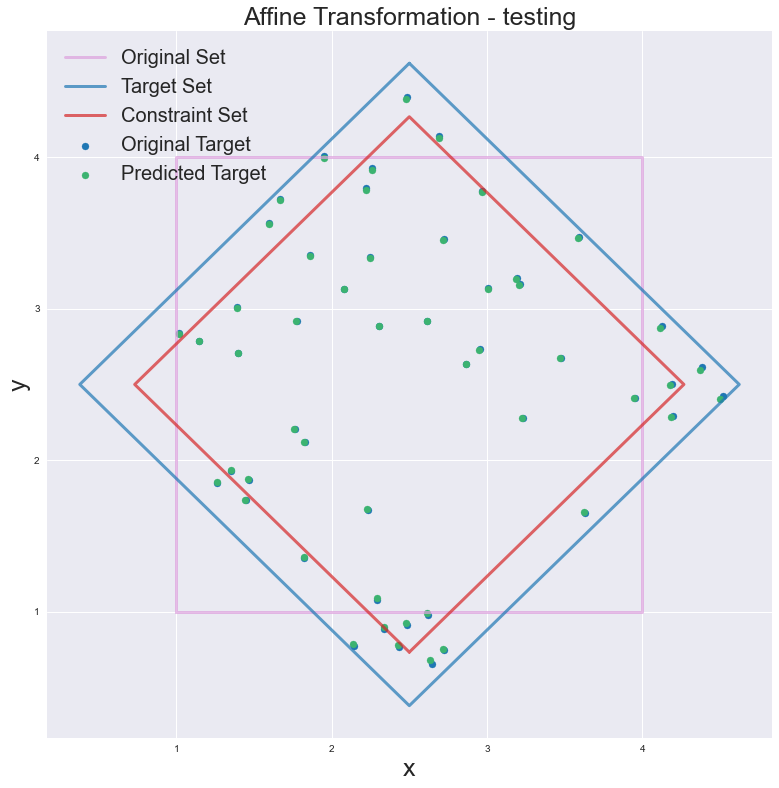

In [18]:
plt.plot(
    x_poly_orig_bound,
    y_poly_orig_bound,
    color="plum",
    alpha=0.7,
    linewidth=3,
    solid_capstyle="round",
    zorder=2,
    label="Original Set",
)
plt.plot(
    x_poly_trans_bound,
    y_poly_trans_bound,
    color="tab:blue",
    alpha=0.7,
    linewidth=3,
    solid_capstyle="round",
    zorder=2,
    label="Target Set",
)
plt.plot(
    x_poly_const_bound,
    y_poly_const_bound,
    color="tab:red",
    alpha=0.7,
    linewidth=3,
    solid_capstyle="round",
    zorder=2,
    label="Constraint Set",
)
plt.scatter(
    y_test[:, 0],
    y_test[:, 1],
    color="tab:blue",
    label="Original Target",
)
y_predict_test = model_orig.predict(x_test)
plt.scatter(
    y_predict_test[:, 0],
    y_predict_test[:, 1],
    color="mediumseagreen",
    label="Predicted Target",
)
plt.rcParams["figure.figsize"] = (13,13)
plt.legend(loc="upper left", frameon=False, fontsize=20)
plt.title(r"Affine Transformation - testing", fontsize=25)
plt.xlabel("x", fontsize=25)
plt.ylabel("y", fontsize=25)
plt.show()

## Saving Data and Model

Here we save the trained model and data set.

In [19]:
if not os.path.exists(path):
    os.makedirs(path + "/model")
    
keras.models.save_model(
    model_orig,
    path + "/model",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True,
)

if not os.path.exists(path + "/data"):
    os.makedirs(path + "/data")
with open(path + "/data/input_output_data_tc1.pickle", "wb") as data:
    pickle.dump([x_train, y_train, x_test, y_test], data)

2022-04-28 22:34:15.187074: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/keyvanmajd/Documents/NNRepLayer_v2/demos/Affine Transform Demo Tensorflow/original_net/model/assets
